In [25]:
import bagpy
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import copy

def find_closest_values(s, x):
    idx = (np.abs(s - x)).argmin()
    return idx
    
def crop_df_time(df, start_time, end_time):
    
    start_index = find_closest_values(df['Time'], start_time)
    end_index = find_closest_values(df['Time'], end_time)
    return df[start_index:end_index]

def upsample_dataframes(df1, df2):
    # Check which dataframe has fewer measurements
    if len(df1) < len(df2):
        shorter_df, longer_df = df1, df2
    else:
        shorter_df, longer_df = df2, df1

    # Calculate the ratio for upsampling
    ratio = len(longer_df) // len(shorter_df)

    # Upsample the shorter dataframe to match the length of the longer dataframe
    upsampled_shorter_df = pd.concat([shorter_df] * ratio, ignore_index=True)

    # Trim the longer dataframe to match the length of the shorter dataframe
    trimmed_longer_df = longer_df.iloc[:len(upsampled_shorter_df)]

    return trimmed_longer_df, upsampled_shorter_df

def scale_time(df): 
    
    df_ = copy.deepcopy(df)
    df_['Time'] = df['Time'] - df['Time'][0]
    return df_

def plot_position(pandas_odometry): 
    t = pandas_odometry['Time']
    x = pandas_odometry['pose.pose.position.x']
    y = pandas_odometry['pose.pose.position.y']
    z = pandas_odometry['pose.pose.position.z']
    
    plt.figure(figsize=(14, 5))

    # Plot positions over time
    plt.plot(t, x, label='X Position', color='red')
    plt.plot(t, y, label='Y Position', color='green')
    plt.plot(t, z, label='Z Position', color='blue')

    # Set axis labels and a title
    plt.xlabel('Time (t)')
    plt.ylabel('Position[m]')
    plt.title('Position')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    
def get_relative_position(odom1, odom2): 
    
    t1 = odom1['Time']; t2 = odom2['Time']
    len_t1 = len(t1); len_t2 = len(t2)
    
    if len(t1) > len(t2): 
        len_t1 = len(t2)
    else: 
        len_t2 = len(t1)
        
    print(len_t1)
    print(len_t2)
        
    x1 = odom1['pose.pose.position.x'][:len_t1]
    y1 = odom1['pose.pose.position.y'][:len_t1]
    z1 = odom1['pose.pose.position.z'][:len_t1]
    
    x2 = odom2['pose.pose.position.x'][:len_t2]
    y2 = odom2['pose.pose.position.y'][:len_t2]
    z2 = odom2['pose.pose.position.z'][:len_t2]
    t1 = t1[:len_t1]
    t2 = t2[:len_t2]
    
    t = t1
    x = x1-x2
    y = y1-y2
    z = z1-z2 
    
    return t,x,y,z

def extract_positions(odom1): 
    
    odom1 = scale_time(odom1)
    t = odom1['Time']
    x = odom1['pose.pose.position.x']
    y = odom1['pose.pose.position.y']
    z = odom1['pose.pose.position.z']
    return t, x, y, z
    
def plot_relative_position(t, x, y, z): 
    
    plt.figure(figsize=(10, 6))

    # Plot positions over time
    plt.plot(t, x, label='X Position', linestyle='-')
    plt.plot(t, y, label='Y Position', linestyle='-')#, marker='s')
    plt.plot(t, z, label='Z Position', linestyle='-')#, marker='^')

    # Set axis labels and a title
    plt.xlabel('Time (t)')
    plt.ylabel('Position')
    plt.title('Positions Over Time')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    
def plot_trajectories(x1, y1, z1, x2, y2, z2, fig_w=15, fig_h=15):
    """
    Plots a trajectory in 3D space.

    Parameters:
    - x_coords (list): List of x-coordinates.
    - y_coords (list): List of y-coordinates.
    - z_coords (list): List of z-coordinates.

    Returns:
    - None
    """
    # Create a 3D figure
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory as a 3D line
    ax.plot(x1, y1, z1, label='UAV trajectory', linewidth=1, color='blue')
    ax.plot(x2, y2, z2, label='Net trajectory', linewidth=1, color='red', linestyle='--')

    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()    
    
    fig.savefig('3d_trajectory.svg')
    
def plot_positions(t1, x1, y1, z1, t2, x2, y2, z2, name="Position"):
    """
    Plot positions of two objects over time in a subplot with two subplots (one below the other).

    Parameters:
    - object1_positions: List or NumPy array of positions for object 1 over time.
    - object2_positions: List or NumPy array of positions for object 2 over time.
    - time_values: List or NumPy array of time values.

    Returns:
    - None (displays the plot).
    """
    if len(t1) != len(t2):
        x1, x2 = upsample_dataframes(x1, x2)
        y1, y2 = upsample_dataframes(y1, y2)
        z1, z2 = upsample_dataframes(z1, z2)
        t1, t2 = upsample_dataframes(t1, t2)

    # Create a 2x1 subplot grid
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

    # Plot object 1 positions
    ax1.plot(t1, x1, label='x_uav', color='red')
    ax1.plot(t2, x2, label='x_net', color='red', linestyle='--')
    ax1.set_ylabel('x[m]')
    ax1.grid()
    ax1.legend()

    # Plot object 2 positions
    ax2.plot(t1, y1, label='y_uav', color='green')
    ax2.plot(t2, y2, label='y_net', color='green', linestyle='--')
    ax2.set_ylabel('y[m]')
    ax2.grid()
    ax2.legend()
    
    ax3.plot(t1, z1, label="z_uav", color='blue')
    ax3.plot(t2, z2, label='z_net', color='blue', linestyle='--')
    ax3.set_ylabel('z[m]')
    ax3.set_xlabel('t[s]')
    ax3.grid()
    ax3.legend()

    # Set a title for the entire subplot
    plt.suptitle('Position [m]')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    fig.savefig('{}.svg'.format(name))
    
def find_topic_name_and_index(topic_name, csv_files): 
    for i, name in enumerate(csv_files): 
        if topic_name in name: 
            print("index: {}; topic_name: {}".format(i, name))

In [4]:
# First fly test 
bag_name = "./bags/first_fly_test.bag" 

bag_paths = []
for bag_name in os.listdir("./bags"):
    bag_paths.append("./bags/{}".format(bag_name))

print(bag_paths)
b = bagreader(bag_paths[3])

['./bags/_2023-09-07-15-48-44.bag', './bags/compressed_img_stationary.bag', './bags/pose_cmd', './bags/bezier_first_try.bag', './bags/_2023-09-07-15-41-47.bag', './bags/pose_cmd.bag', './bags/second_fly_test.bag', './bags/bags_2023-09-07-15-34-23.bag', './bags/catch_try', './bags/first_fly_test.bag', './bags/catch_try.bag', './bags/_2023-09-07-15-41-47', './bags/fourth_try_test.bag', './bags/third_fly_test.bag', './bags/_2023-09-07-15-34-52.bag']
[INFO]  Successfully created the data folder ./bags/bezier_first_try.


In [5]:
csv_files = []
for topic in b.topics:
    data = b.message_by_topic(topic)
    csv_files.append(data)

In [28]:
topic_name = "detected"
find_topic_name_and_index(topic_name, csv_files)


index: 0; topic_name: ./bags/bezier_first_try/detected_objects.csv
index: 1; topic_name: ./bags/bezier_first_try/detected_poses.csv


In [29]:
det_objs = pd.read_csv(csv_files[0])
det_poses = pd.read_csv(csv_files[1])
uav_pose = pd.read_csv(csv_files[3]); uav_pose = scale_time(uav_pose)
net_pose = pd.read_csv(csv_files[8]); net_pose = scale_time(net_pose)

## UAV and Net position

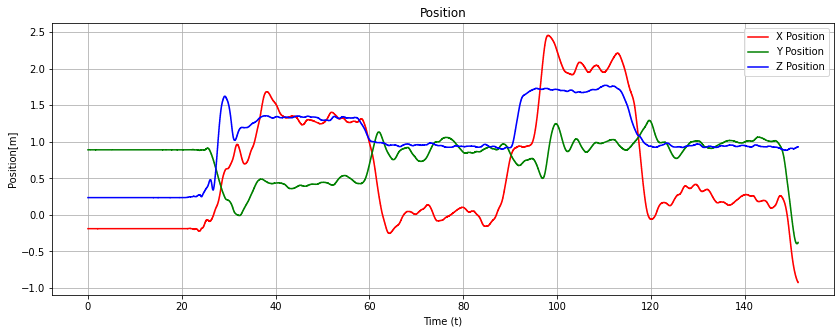

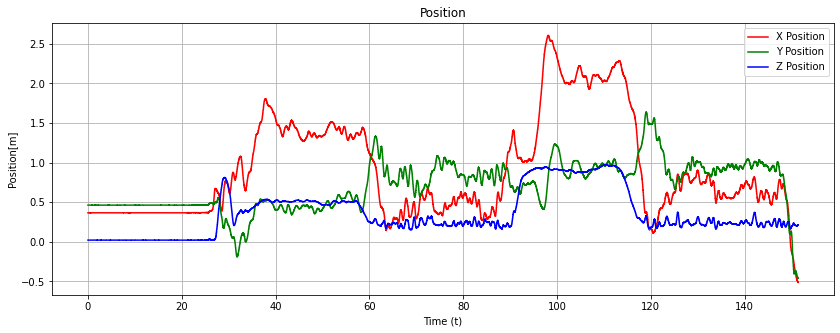

In [8]:
plot_position(uav_pose)
plot_position(net_pose)

In [18]:
t1,x1,y1,z1 = extract_positions(uav_pose)
t2,x2,y2,z2 = extract_positions(net_pose)
print(len(t1), len(t2))

35887 35686


## UAV and net position subplot

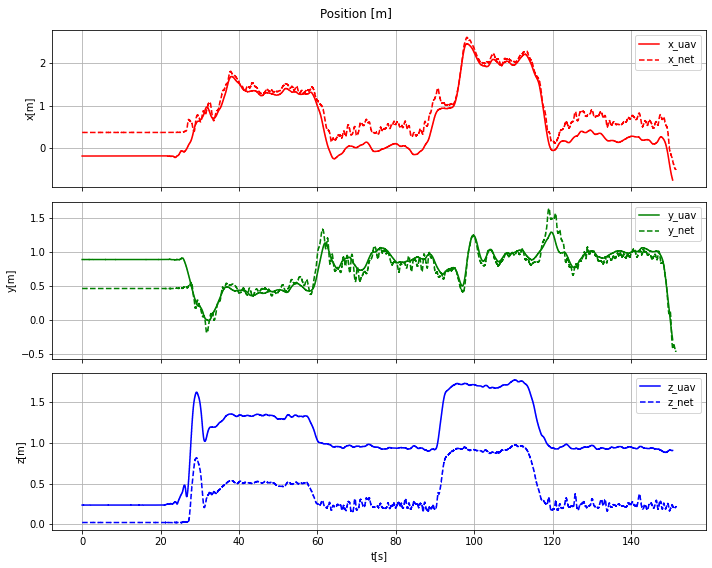

In [21]:
plot_positions(t1, x1, y1, z1, t2, x2, y2, z2)

## 3D trajectory plot of the UAV and the Net

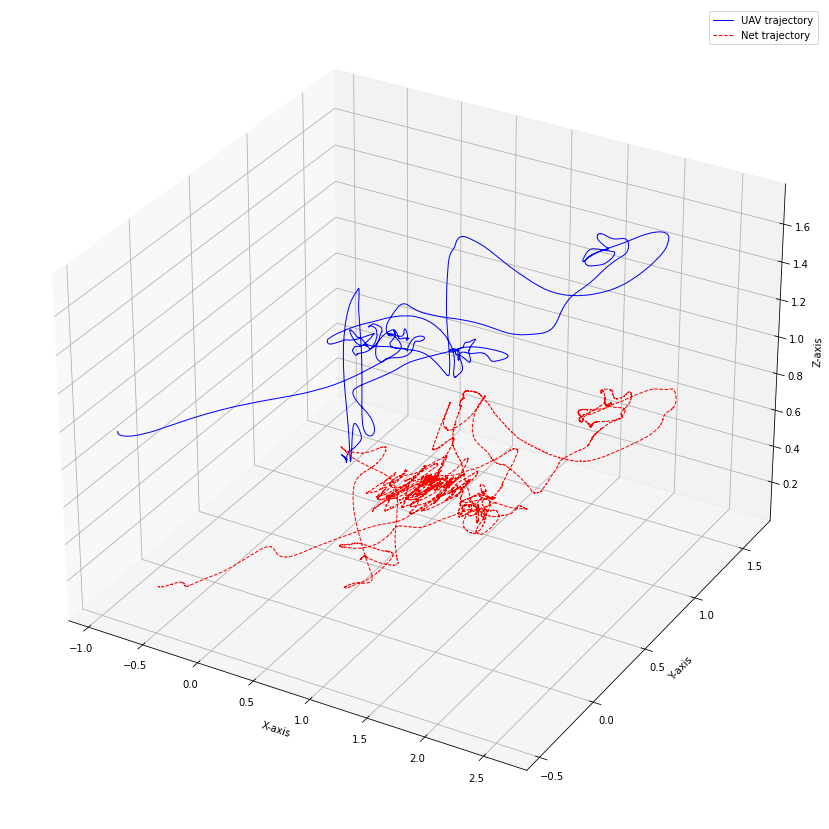

In [22]:
plot_trajectories(x1, y1, z1, x2, y2, z2)

In [47]:
poses = det_poses['poses']
def extract_poses(det_poses): 
    poses = det_poses['poses']
    for i in poses: 
        i = i.split(" ")
        x = 
        print(i)
extract_poses(det_poses)

['[pose:', '\n', '', 'x:', '0.8975622653961182\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8975622653961182\n', '', 'y:', '-0.5240288972854614\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8975622653961182\n', '', 'y:', '-0.5240288972854614\n', '', 'z:', '1.564000129699707\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '-0.5129720568656921\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '-0.5129720568656921\n', '', 'z:', '1.531000018119812\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '-0.5129720568656921\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '-0.5129720568656921\n', '', 'z:', '1.531000018

['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '-0.8383122086524963\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '-0.8383122086524963\n', '', 'z:', '2.502000093460083\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '-0.8383122086524963\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '-0.8383122086524963\n', '', 'z:', '2.502000093460083\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.6662687063217163\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.6662687063217163\n', '', 'y:', '-0.8852202296257019\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.6662687063217163\n', '', 'y:', '-0.8852202296257019\n', '', 'z:', '2.642000198364258\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.6662687063217163\n', '', 'y:', '0.0\n',

In [108]:
#t, x, y, z = get_relative_position(uav_pose_new, net_pose_new)
#plot_relative_position(t, x, y, z)
#uav_pose_new, net_pose_new = upsample_dataframes(uav_pose, net_pose)

# TODO: 
- [x] Plot UAV and the NET position 
- [x] Plot relative position
- [x] Plot net orientation
- [ ] Increase fonts and legends
- [x] Plot Bezier for starters and check pool 
- [ ] Plot UAV and the NET position for the multiple times 
- [ ] Crop method based on the time
- [ ] Plot relative position between UAV - NET (done) and Object (not done)  

## Findings: 
- [x] When optitrack loses markers, we lose measurements (more optitrack markers)
- [ ] Optitrack markers on a can (to record even relative position between net and the object) 
